In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import time
import sys
import os
import pickle
import json
import copy
import itertools
import collections
import warnings
import scipy
import scipy.stats
import scipy.sparse
import scipy.sparse.linalg
import scipy.sparse.csgraph
import scipy.sparse.csgraph._validation
import scipy.sparse.csgraph._shortest_path
import scipy.sparse.csgraph._tools
import scipy.sparse.csgraph._traversal
import scipy.sparse.csgraph._min_spanning_tree
import scipy.sparse.csgraph._reordering
import scipy.sparse.csgraph._laplacian
import scipy.sparse.csgraph._flow
import scipy.sparse.csgraph._matching
import scipy.sparse.csgraph._reordering
import scipy.sparse.csgraph._min_spanning_tree

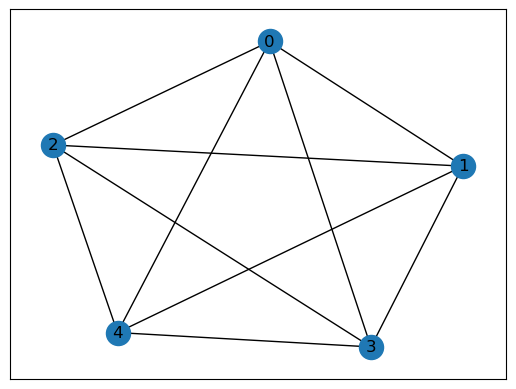

In [6]:
G = nx.complete_graph(5)
nx.draw_networkx(G)

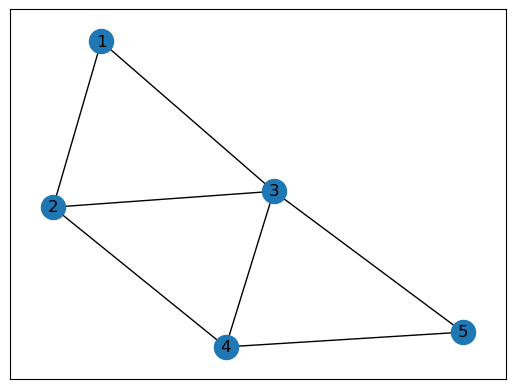

In [7]:
## visualize a simple graph
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5])
G.add_edges_from([(1,2),(1,3),(2,3),(2,4),(3,4),(3,5),(4,5)])
nx.draw_networkx(G, with_labels=True)
plt.show()

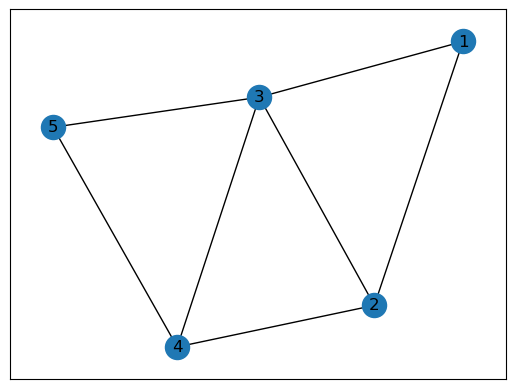

In [8]:
## using seaborn to make a simple graph more beautiful
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5])
G.add_edges_from([(1,2),(1,3),(2,3),(2,4),(3,4),(3,5),(4,5)])
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True)
plt.show()


In [1]:
import pgmpy as pmp

/Users/averyzhou/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from IPython.display import display as d
import math

In [6]:
### timing probabilities together normally 
prob1 = 0.5
prob2 = 0.5
fin_prob_normal = prob1 * prob2

### timing probabilities together using log probabilities
log_prob1 = math.log(prob1)
log_prob2 = math.log(prob2)
fin_log_prob = log_prob1 + log_prob2
fin_prob_log = math.exp(fin_log_prob)

d(fin_prob_normal)
d(fin_prob_log)

0.25

0.25

In [7]:
def log_sum_exp(prob_1, prob_2) -> float:
    """Return the product of two probabilities through log space."""
    return math.exp(math.log(prob_1) + math.log(prob_2))

In [24]:
import pandas as pd
from pandas import DataFrame as DF

In [25]:
class HMM(object):
    """
    A class for implementing HMMs.

    Attributes
    ----------
    envShape : list
        A two element list specifying the shape of the environment
    states : list
        A list of states specified by their (x, y) coordinates
    observations : list
        A list specifying the sequence of observations
    T : numpy.ndarray
        An N x N array encoding the transition probabilities, where
        T[i,j] is the probability of transitioning from state i to state j.
        N is the total number of states (envShape[0]*envShape[1])
    M : numpy.ndarray
        An M x N array encoding the emission probabilities, where
        M[k,i] is the probability of observing k from state i.
    pi : numpy.ndarray
        An N x 1 array encoding the prior probabilities

    Methods
    -------
    train(observations)
        Estimates the HMM parameters using a set of observation sequences
    viterbi(observations)
        Implements the Viterbi algorithm on a given observation sequence
    setParams(T, M, pi)
        Sets the transition (T), emission (M), and prior (pi) distributions
    getParams
        Queries the transition (T), emission (M), and prior (pi) distributions
    sub2ind(i, j)
        Convert integer (i,j) coordinates to linear index.
    """

    def __init__(self, envShape, T=None, M=None, pi=None) -> None:
        """
        Initialize the class.

        Attributes
        ----------
        envShape : list
            A two element list specifying the shape of the environment
        T : numpy.ndarray, optional
            An N x N array encoding the transition probabilities, where
            T[i,j] is the probability of transitioning from state i to state j.
            N is the total number of states (envShape[0]*envShape[1])
        M : numpy.ndarray, optional
            An M x N array encoding the emission probabilities, where
            M[k,i] is the probability of observing k from state i.
        pi : numpy.ndarray, optional
            An N x 1 array encoding the prior probabilities
        """
        self.envShape = envShape
        self.numStates = envShape[0] * envShape[1]

        if T is None:
            # Initial estimate of the transition function
            # where T[sub2ind(i',j'), sub2ind(i,j)] is the likelihood
            # of transitioning from (i,j) --> (i',j')
            self.T = np.zeros((self.numStates, self.numStates))

            # Self-transitions
            for i in range(self.numStates):
                self.T[i, i] = 0.2

            # Black rooms
            self.T[self.sub2ind(0, 0), self.sub2ind(0, 0)] = 1.0
            self.T[self.sub2ind(1, 1), self.sub2ind(1, 1)] = 1.0
            self.T[self.sub2ind(0, 3), self.sub2ind(0, 3)] = 1.0
            self.T[self.sub2ind(3, 2), self.sub2ind(3, 2)] = 1.0

            # (1, 0) -->
            self.T[self.sub2ind(2, 0), self.sub2ind(1, 0)] = 0.8

            # (2, 0) -->
            self.T[self.sub2ind(1, 0), self.sub2ind(2, 0)] = 0.8 / 3.0
            self.T[self.sub2ind(2, 1), self.sub2ind(2, 0)] = 0.8 / 3.0
            self.T[self.sub2ind(3, 0), self.sub2ind(2, 0)] = 0.8 / 3.0

            # (3, 0) -->
            self.T[self.sub2ind(2, 0), self.sub2ind(3, 0)] = 0.8 / 2.0
            self.T[self.sub2ind(3, 1), self.sub2ind(3, 0)] = 0.8 / 2.0

            # (0, 1) --> (0, 2)
            self.T[self.sub2ind(0, 2), self.sub2ind(0, 1)] = 0.8

            # (2, 1) -->
            self.T[self.sub2ind(2, 0), self.sub2ind(2, 1)] = 0.8 / 3.0
            self.T[self.sub2ind(3, 1), self.sub2ind(2, 1)] = 0.8 / 3.0
            self.T[self.sub2ind(2, 2), self.sub2ind(2, 1)] = 0.8 / 3.0

            # (3, 1) -->
            self.T[self.sub2ind(2, 1), self.sub2ind(3, 1)] = 0.8 / 2.0
            self.T[self.sub2ind(3, 0), self.sub2ind(3, 1)] = 0.8 / 2.0

            # (0, 2) -->
            self.T[self.sub2ind(0, 1), self.sub2ind(0, 2)] = 0.8 / 2.0
            self.T[self.sub2ind(1, 2), self.sub2ind(0, 2)] = 0.8 / 2.0

            # (1, 2) -->
            self.T[self.sub2ind(0, 2), self.sub2ind(1, 2)] = 0.8 / 3.0
            self.T[self.sub2ind(2, 2), self.sub2ind(1, 2)] = 0.8 / 3.0
            self.T[self.sub2ind(1, 3), self.sub2ind(1, 2)] = 0.8 / 3.0

            # (2, 2) -->
            self.T[self.sub2ind(1, 2), self.sub2ind(2, 2)] = 0.8 / 3.0
            self.T[self.sub2ind(2, 1), self.sub2ind(2, 2)] = 0.8 / 3.0
            self.T[self.sub2ind(2, 3), self.sub2ind(2, 2)] = 0.8 / 3.0

            # (1, 3) -->
            self.T[self.sub2ind(1, 2), self.sub2ind(1, 3)] = 0.8 / 2.0
            self.T[self.sub2ind(2, 3), self.sub2ind(1, 3)] = 0.8 / 2.0

            # (2, 3) -->
            self.T[self.sub2ind(1, 3), self.sub2ind(2, 3)] = 0.8 / 3.0
            self.T[self.sub2ind(3, 3), self.sub2ind(2, 3)] = 0.8 / 3.0
            self.T[self.sub2ind(2, 2), self.sub2ind(2, 3)] = 0.8 / 3.0

            # (3, 3) --> (2, 3)
            self.T[self.sub2ind(2, 3), self.sub2ind(3, 3)] = 0.8
        else:
            self.T = T

        if M is None:
            # Initial estimates of emission likelihoods, where
            # M[k, sub2ind(i,j)]: likelihood of observation k from state (i, j)
            self.M = np.ones((4, 16)) * 0.1

            # Black states
            self.M[:, self.sub2ind(0, 0)] = 0.25
            self.M[:, self.sub2ind(1, 1)] = 0.25
            self.M[:, self.sub2ind(0, 3)] = 0.25
            self.M[:, self.sub2ind(3, 2)] = 0.25

            self.M[self.obs2ind("r"), self.sub2ind(0, 1)] = 0.7
            self.M[self.obs2ind("g"), self.sub2ind(0, 2)] = 0.7
            self.M[self.obs2ind("g"), self.sub2ind(1, 0)] = 0.7
            self.M[self.obs2ind("b"), self.sub2ind(1, 2)] = 0.7
            self.M[self.obs2ind("r"), self.sub2ind(1, 3)] = 0.7
            self.M[self.obs2ind("y"), self.sub2ind(2, 0)] = 0.7
            self.M[self.obs2ind("g"), self.sub2ind(2, 1)] = 0.7
            self.M[self.obs2ind("r"), self.sub2ind(2, 2)] = 0.7
            self.M[self.obs2ind("y"), self.sub2ind(2, 3)] = 0.7
            self.M[self.obs2ind("b"), self.sub2ind(3, 0)] = 0.7
            self.M[self.obs2ind("y"), self.sub2ind(3, 1)] = 0.7
            self.M[self.obs2ind("b"), self.sub2ind(3, 3)] = 0.7
        else:
            self.M = M

        if pi is None:
            # Initialize estimates of prior probabilities where
            # pi[(i, j)] is the likelihood of starting in state (i, j)
            self.pi = np.ones((16, 1)) / 12
            self.pi[self.sub2ind(0, 0)] = 0.0
            self.pi[self.sub2ind(1, 1)] = 0.0
            self.pi[self.sub2ind(0, 3)] = 0.0
            self.pi[self.sub2ind(3, 2)] = 0.0
        else:
            self.pi = pi

    def computeXis(self, alpha, beta, z):
        """Compute xi as an array comprised of each xi-xj pair."""
        pass

    def getLogStartProb(self, state):
        """Return the log probability of a particular state."""
        return np.log(self.pi[state])

    def getLogTransProb(self, fromState, toState):
        """Return the log probability associated with a state transition."""
        return np.log(self.T[toState, fromState])

    def getLogOutputProb(self, state, output):
        """Return the log probability of a state-dependent observation."""
        return np.log(self.M[output, state])

    def sub2ind(self, i, j):
        """Convert subscript (i,j) to linear index."""
        return self.envShape[1] * i + j

    def obs2ind(self, obs):
        """Convert observation string to linear index."""
        obsToInt = {"r": 0, "g": 1, "b": 2, "y": 3}
        return obsToInt[obs]

In [26]:
h = HMM

In [27]:
import pickle
import sys

from DataSet import DataSet
from HMM import HMM

In [28]:
dataset = DataSet(r'./data/randomwalk.train.txt')
dataset.readFile()

hmm = HMM(dataset.envShape)
# hmm.train(dataset.observations)

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [77]:
def plot_heatmap(data, title, xLabel, yLabel, annot=False, fmt=".1f", cmap='viridis', show=True):
    sns.heatmap(data, annot=annot, fmt=fmt, cmap=cmap)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    if show:
        plt.show()
    return plt

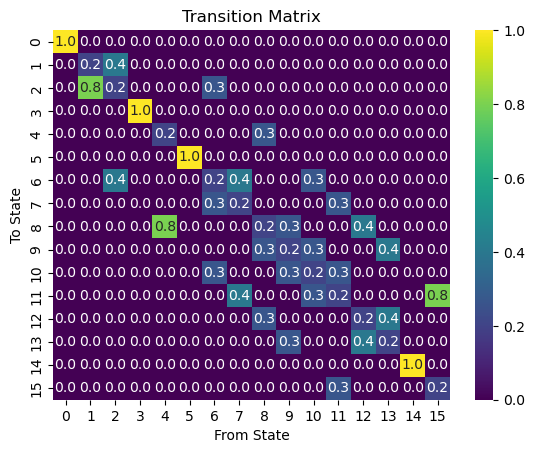

<module 'matplotlib.pyplot' from '/Users/averyzhou/miniconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [78]:
plot_heatmap(hmm.T, "Transition Matrix", "From State", "To State", annot=True)

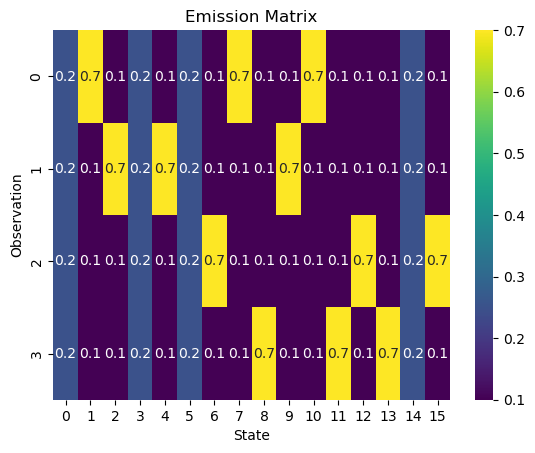

<module 'matplotlib.pyplot' from '/Users/averyzhou/miniconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [81]:
plot_heatmap(hmm.M, "Emission Matrix", "State", "Observation", annot=True)

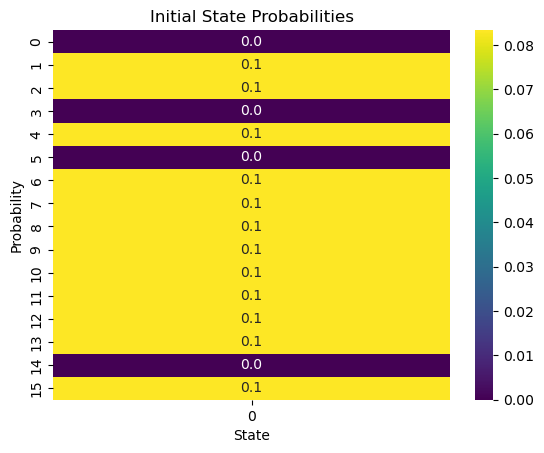

<module 'matplotlib.pyplot' from '/Users/averyzhou/miniconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [82]:
plot_heatmap(hmm.pi, "Initial State Probabilities", "State", "Probability", annot=True)

In [2]:
import numpy as np
np.ones((4, 16))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [3]:
np.ones((4, 16)).T

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [4]:
display(np.ones((4, 16)).shape)
display(np.ones((4, 16)).T.shape)


(4, 16)

(16, 4)

In [1]:
0.3 * 0.7

0.21

In [3]:
from scipy.special import logsumexp
logsumexp([0.3, 0.7])

1.2130152523999524